https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

# time-series-forecasting-wiki
This repository tries to encapsulate the basics of time series forecasting. I will talk through the basics of time series analysis and give an overview of the most efective methods I have encountered for both Univariate and Multivariate series.


  



# Why this repository?

In [1]:
###

# Table of contents

In [9]:
!conda install matplotlib

Solving environment: done

# All requested packages already installed.



In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from utils.metrics import evaluate
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn import linear_model, svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from math import sqrt
from xgboost import plot_importance, plot_tree
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization


#Extra settings
tf.executing_eagerly()
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.1.0


In [5]:
#Download the required python libraries executing this cell
!pip install -r  requirements.txt --no-cache
#!cat requirements.txt | xargs -n 1 pip install #For more robust install, only works in linux

# The dataset

We will be using the [Beijing air quality dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv) containing an air pollution measurement from 2011 to 2014. The dataset also contains extra weather features such as wind speed, wind direction or even if its raining. Measurements are /hour but we will group them into daily measurements for simplicity. Special thanks to Jason Brownlee for publishing it in his github and his webpage https://machinelearningmastery.com/.

The file is downloaded and preprocessed in our [script](https://github.com/jiwidi/time-series-forecasting-wiki/blob/master/datasets/download_datasets.py) on the dataset folder. After #EXPLAIN PROCESSING

The resulting file contains the following columns:

* date
* pollution_today
* dew
* temp
* press
* wnd_spd
* snow
* rain
* pollution_tomorrow




In [4]:
#Execute the script to download and process the dataset by running this cell
!python datasets/download_datasets.py

INFO:__main__:Processing air pollution dataset
/Users/jafen/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:__main__:Saving air pollution dataset to/Users/jafen/Documents/github/time-series-forecasting-wiki/datasets
INFO:__main__:Air pollution dataset processed
INFO:__main__:Processing done


## Load the dataset and quick preview

In [5]:
air_pollution = pd.read_csv('datasets/air_pollution.csv',parse_dates=['date'])
air_pollution.set_index('date',inplace=True)
air_pollution.head() #Preview our dataset

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [6]:
air_pollution.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


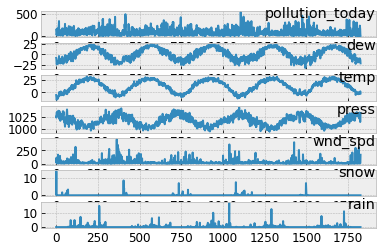

In [7]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

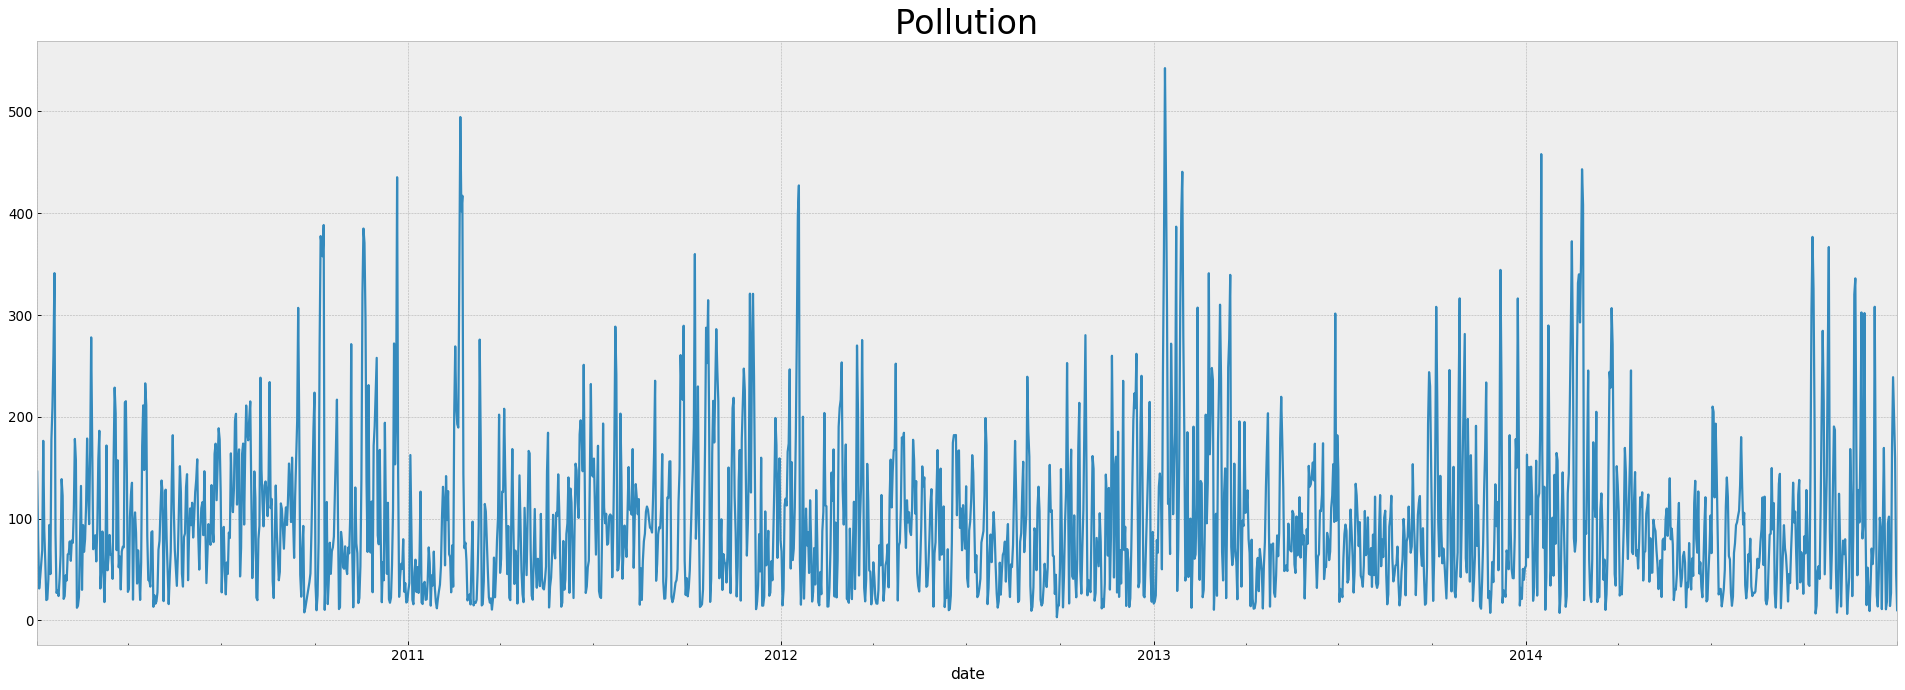

In [8]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Pollution',fontsize=30)

air_pollution.pollution_today.plot()

# Time series basic analysis

## Decomposing our time series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

##### Additive Model
`y(t) = Level + Trend + Seasonality + Noise`

Additives models are lineal. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time
   
##### Multiplicative model
`y(t) = Level * Trend * Seasonality * Noise`

Multiplicatives models are nonlinear,trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways. 

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model. 

##### Automatic time series decomposition

Statsmodel python library provides a function [seasonal_compose()](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to automatically decompose a time series, you still need to specify wether the model is additive or multiplicative. We will use multiplicative as our quick peak at the pm2.5 time series shows no linear trend.

<Figure size 4000x1600 with 0 Axes>

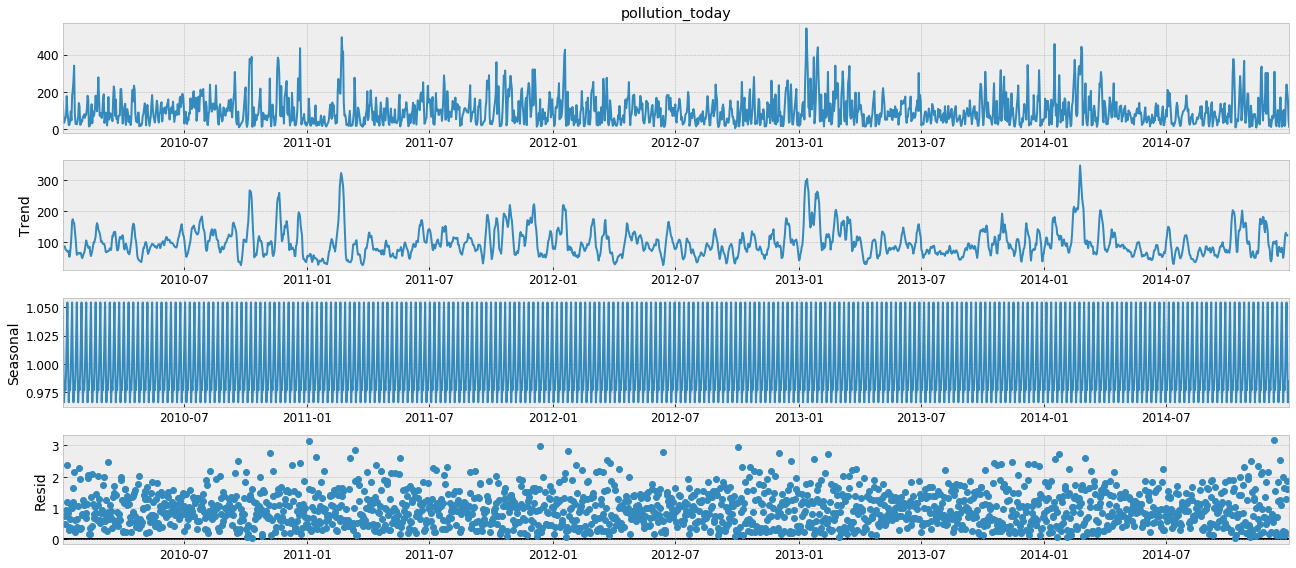

In [9]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

## Seasonality
We just saw how Seasonality can be one of the most determinants components of a time series. Seasonalities show periodic fluctiations that repeat over time. For example the amount of sunscream protector (always low in winter and high in summer).

The previous chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

Lets go with the first year of data only now:

<Figure size 4000x1600 with 0 Axes>

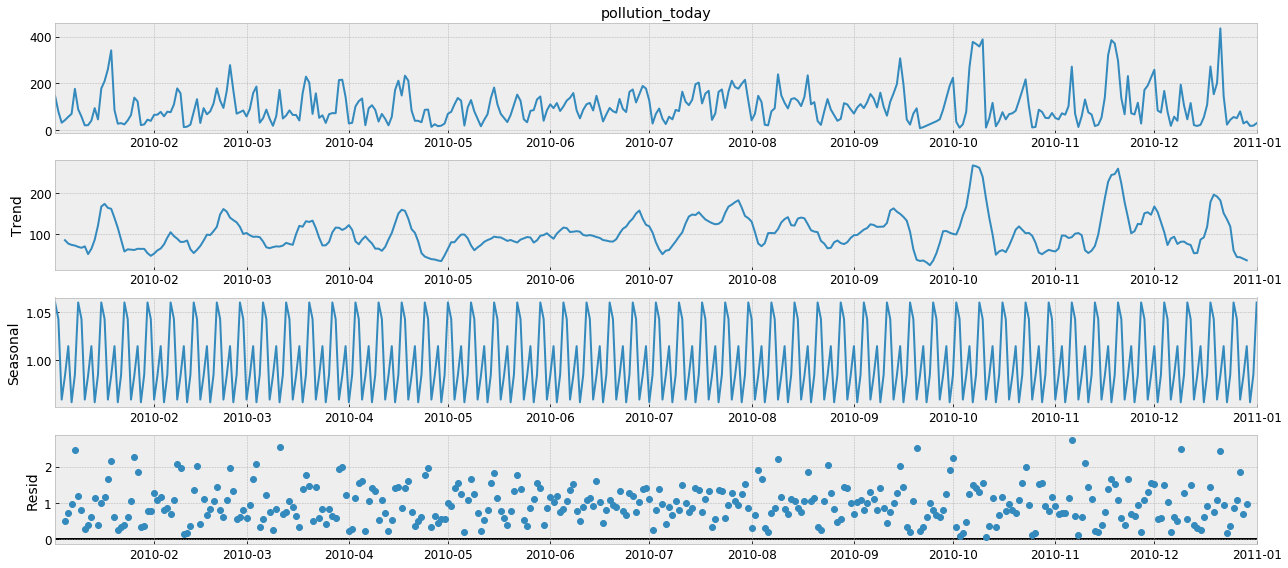

In [10]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

Here can see a clear weekly trend, 4 spikes every month (weerkly). Lets check how the last year of data looks

<Figure size 4000x1600 with 0 Axes>

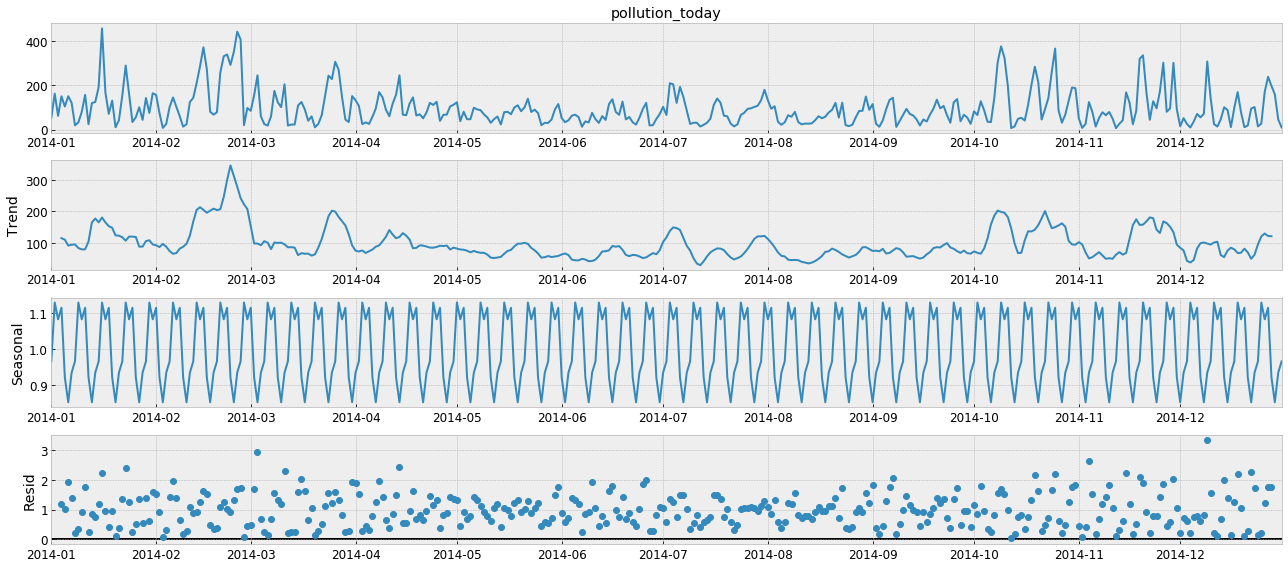

In [11]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

We see another weekly seasonality(4 spikes between every month) but a bit different to the original one, this is something we should always expect from real datasets as their seasonalities will never be perfect but a combination of multiples.

##INTERPRETATION

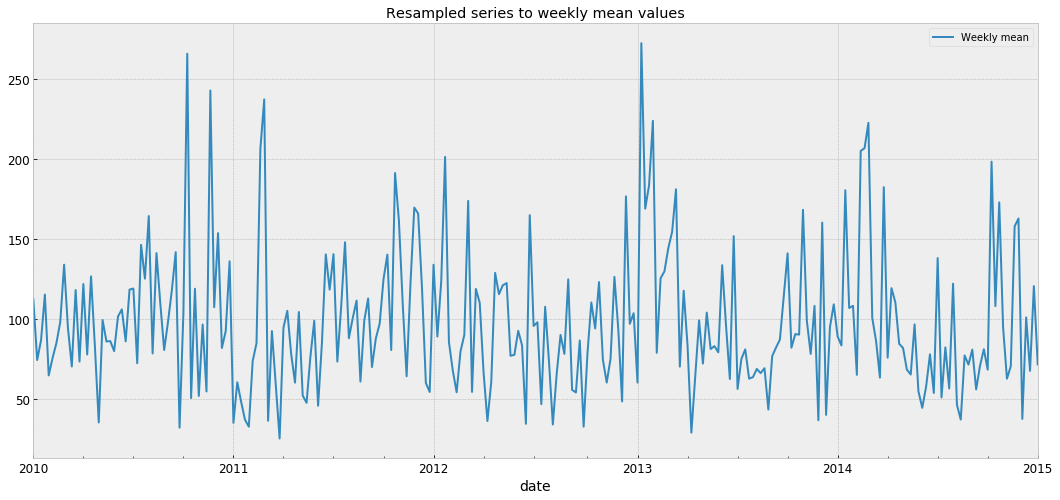

In [12]:
#Looking for weekly seasonality
resample = air_pollution.resample('W')
weekly_mean = resample.mean()
weekly_mean.pollution_today.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

### Manual methods to find seasonalities

We can also try to generate a model to find the seasonalities for us. One of the most common to use is a simple polynomial model.

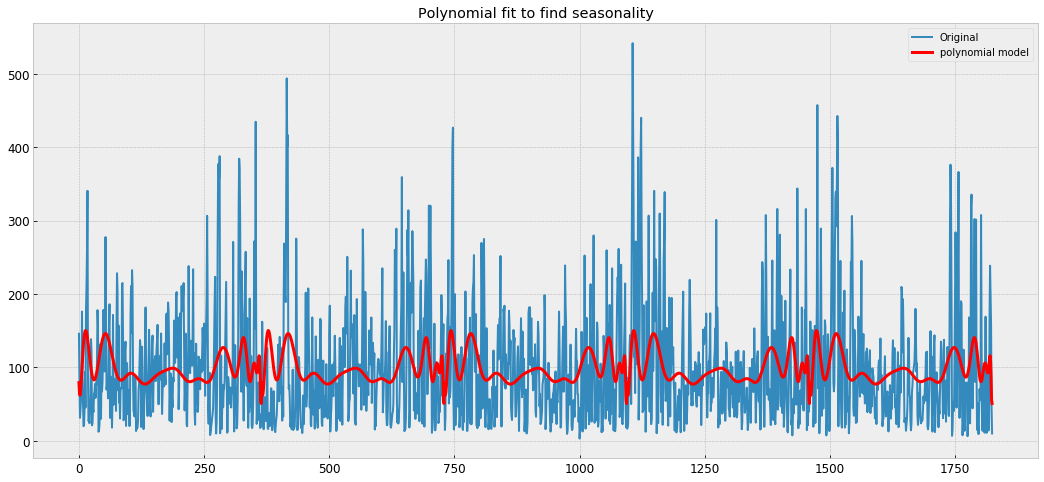

In [13]:
#Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = air_pollution.pollution_today.values
X = [i%365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series,label='Original')
plt.plot(curve, color='red', linewidth=3,label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

We can see how the model to find a seasonality fits poorly to our data. Is going to be a complicate time series to model :P 

## Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

### Check for sationarity




### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time


#EXPLAIN AUTOCORRELATION

<Figure size 1296x576 with 0 Axes>

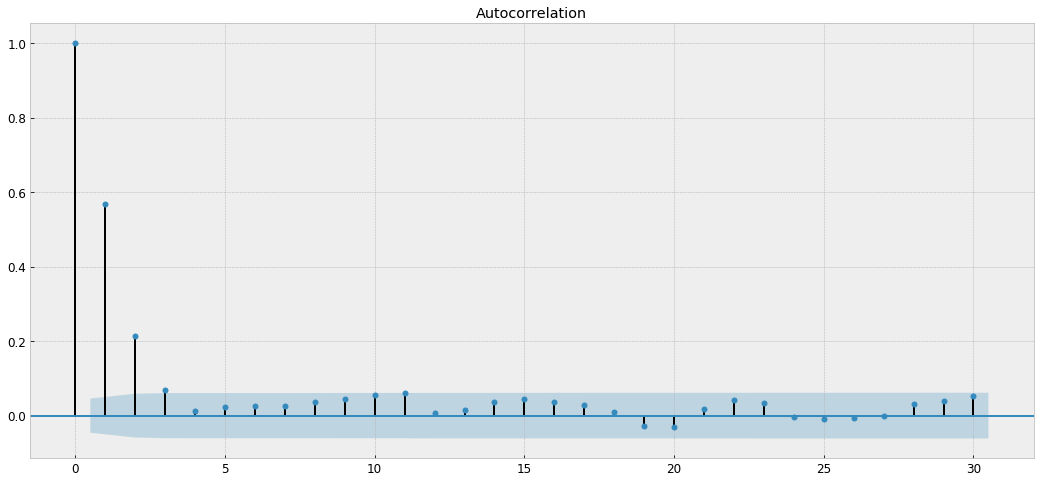

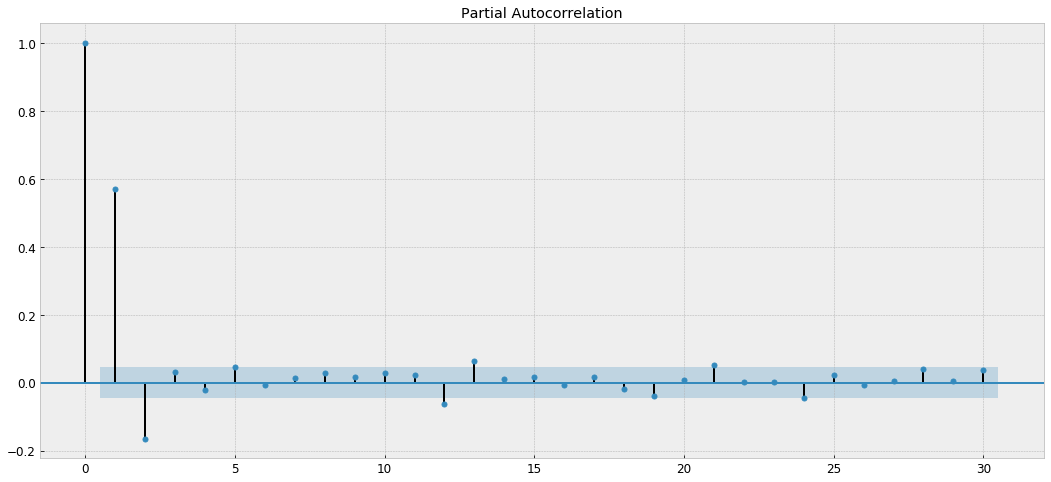

In [14]:
plt.figure()
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

### Rolling means and std of our series

We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

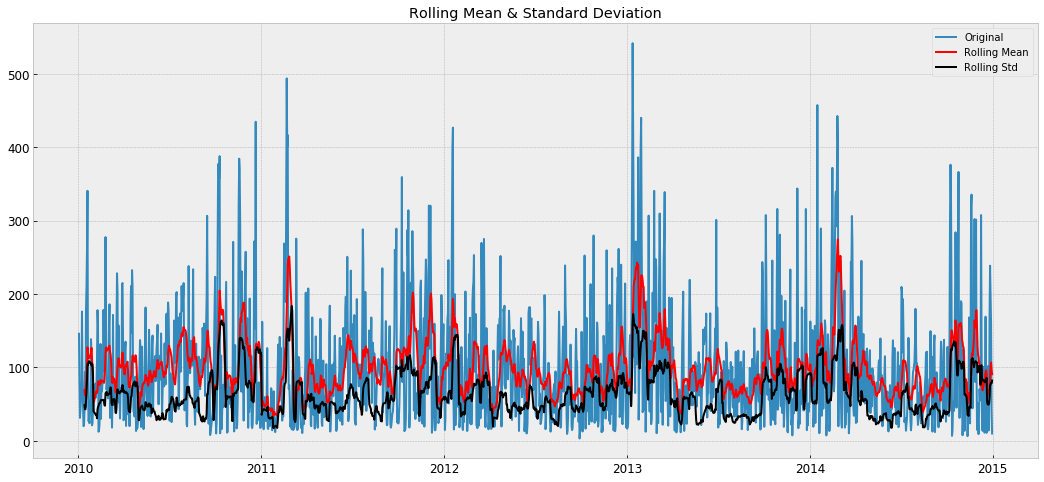

In [15]:
#Determing rolling statistics
rolmean = air_pollution.pollution_today.rolling(window=12).mean()
rolstd = air_pollution.pollution_today.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(air_pollution.pollution_today,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us again a stationary series

### Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.


In [16]:

X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Here we also provide a method to quickly perform all the previous methods into one single function call and a pretty graph :) 

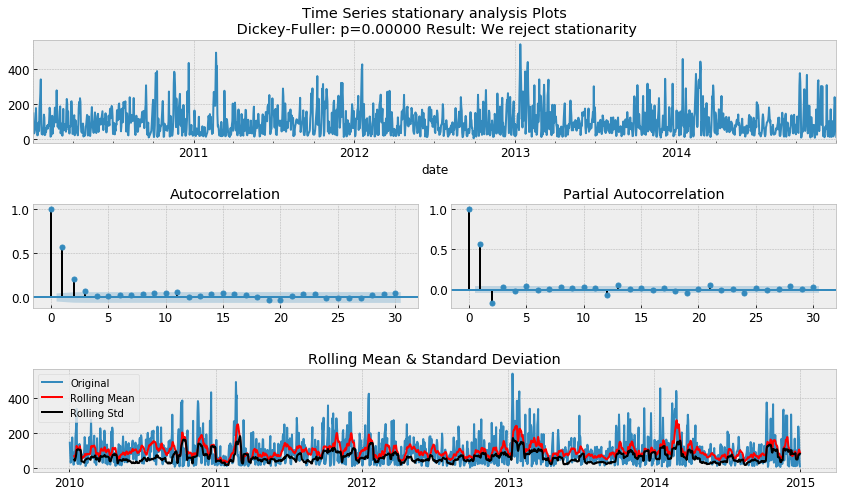

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        mean_std_ax = plt.subplot2grid(layout, (2,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value<=0.05 else "We can not reject stationarity"
        ts_ax.set_title('Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value,hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        #Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today,label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
        
tsplot(air_pollution.pollution_today, lags=30)

## Making Time Series Stationary

##ADD ROLLING MEAN AND ROLLING STD TO ALL CHARTS MUDAFAKAAA

Okay we got lucky with this dataset and is already stationary, but what happens when this is not the case? We included a dummy dataset called `international_airline_passengers.csv` on the datasets folders which is not stationary and we will apply some methods in this section to transform it into a stationary series.

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

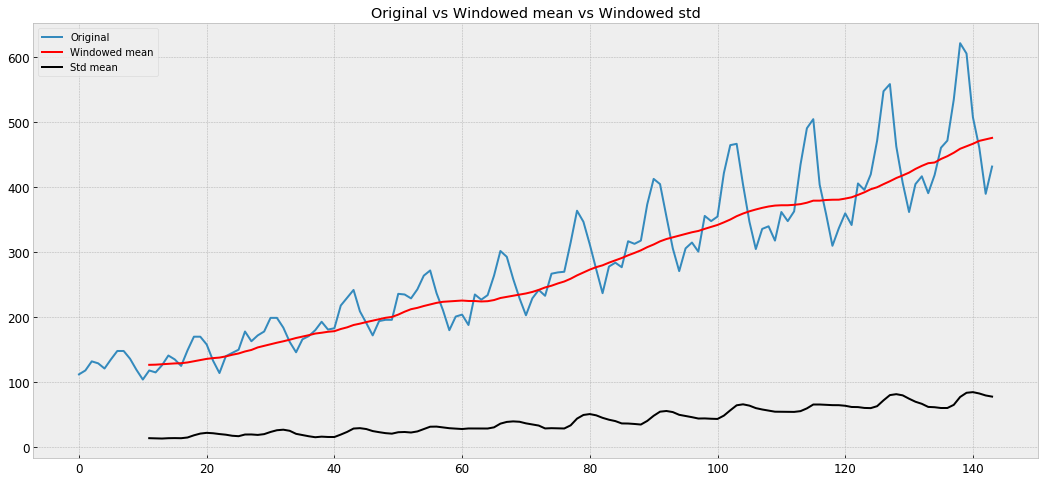

In [18]:
passengers = pd.read_csv("datasets/international_airline_passengers.csv")
passengers.passengers.plot(label='Original')
passengers.passengers.rolling(window=12).mean().plot(color='red', label='Windowed mean')
passengers.passengers.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

Lets run our stationary multitest function over this series

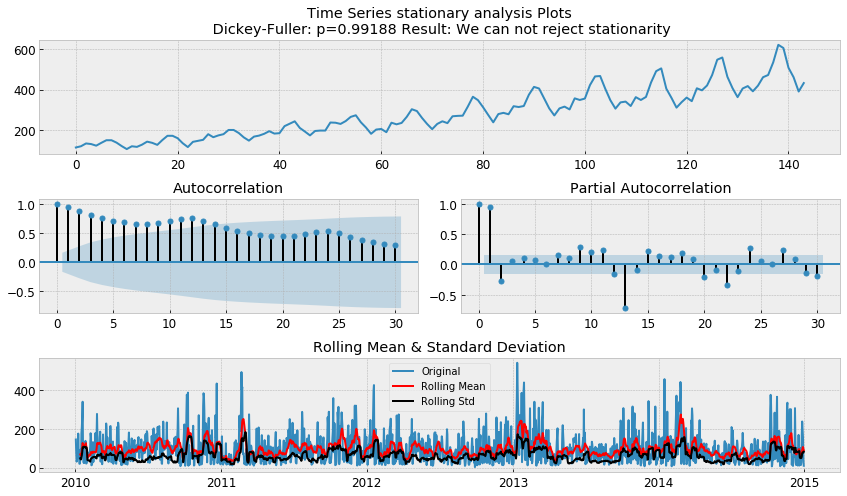

In [19]:
tsplot(passengers.passengers, lags=30)

With a p value of ~1 and high correlation values over time distant samples we need to apply some methods to make the series stationary.

Coming back to the stationary definition, what makes our current series non stationary?

* **Trend** - The mean for our series is not constant, it increases over time

* **Seasonality** - The values of our series vary over time with an specific pattern that repeats over time, this is called seasonalities (spike of people flying on the 24th of December)

Mainly we need to make our mean values as constant as possible and remove seasonalities, we now present some methods to achieve it.

### Difference transform

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`difference(t) = observation(t) - observation(t-1)`

Taking the difference between consecutive observations would be a lag-1 difference, we can tweek this lag value to fit our series.

We can also apply differencing transforms consecutively in the same series if the temporal effect hasnt been removed yet. This is called multiple order difference transform

In [20]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset=diff
    return diff

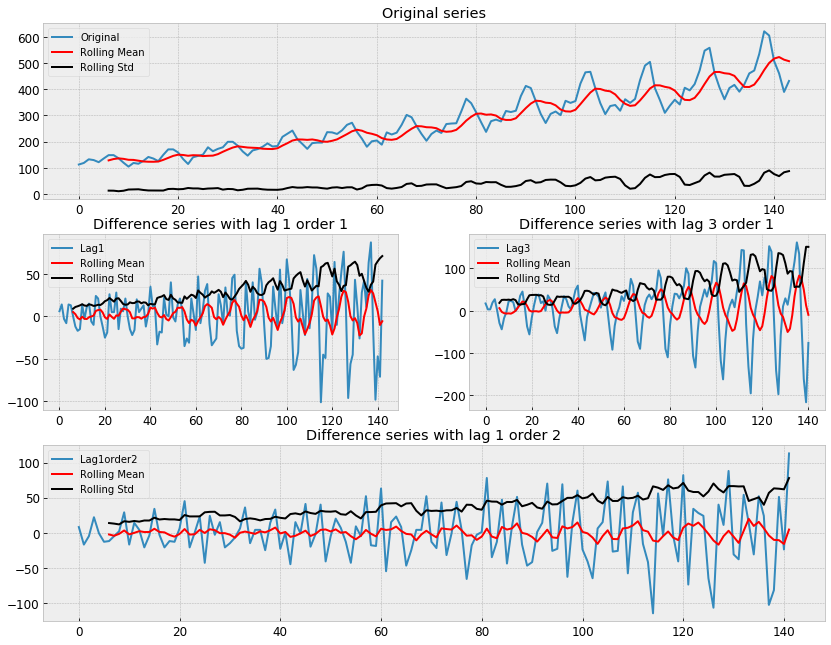

In [21]:
lag1series = pd.Series(difference(passengers.passengers, interval=1, order=1))
lag3series = pd.Series(difference(passengers.passengers, interval=3, order=1))
lag1order2series = pd.Series(difference(passengers.passengers, interval=1, order=2))

fig = plt.figure(figsize=(14,11))
layout = (3,2)
original = plt.subplot2grid(layout, (0,0), colspan=2)
lag1 = plt.subplot2grid(layout, (1,0))
lag3 = plt.subplot2grid(layout, (1,1))
lag1order2 = plt.subplot2grid(layout, (2,0), colspan=2)

original.set_title('Original series')
original.plot(passengers.passengers, label = 'Original')
original.plot(passengers.passengers.rolling(7).mean(), color='red', label='Rolling Mean')
original.plot(passengers.passengers.rolling(7).std(), color='black', label = 'Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label = "Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label = 'Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label = "Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label = 'Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label = "Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(), color='black', label = 'Rolling Std')
lag1order2.legend(loc='best')

We can see how 1 order differencing doesnt really remove stationary but once we go with a order 2 difference it looks closer to a stationary series

### Log scale transformation

Applying a log scale transform to a time series could also  help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`LogScaleTransform(t)= Log(t)`

Text(0.5, 1.0, 'Log scale transformation into original series')

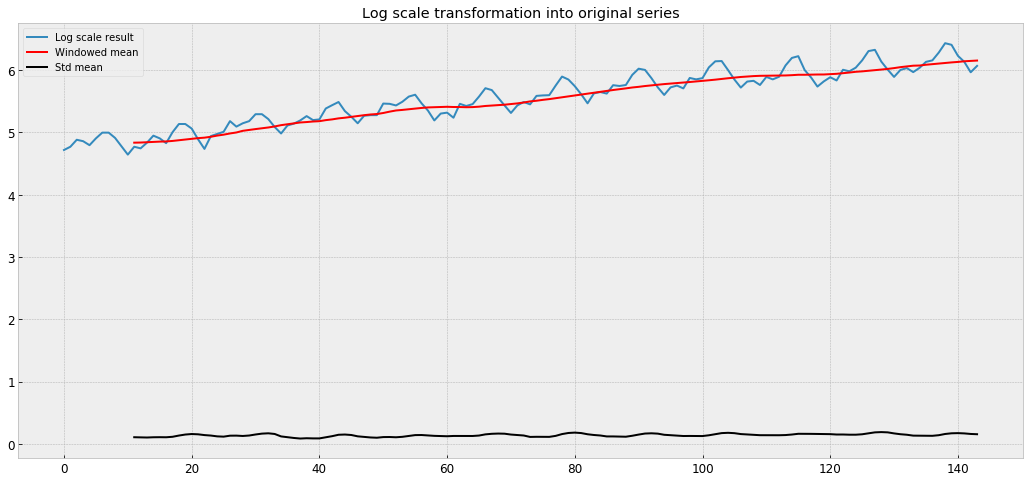

In [22]:
ts_log = np.log(passengers.passengers)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

In [23]:
##COmment results

### Smoothing

We have seen the moving mean as a measure to check stationarity, we can also apply this windows to our series to remove seasonality.

With smotthing we will take rolling averages over periods of time. Is a bit tricky to choose the best windows #MORE ON THIS IN NEXT SECTION WITH AUTO WINDOWS

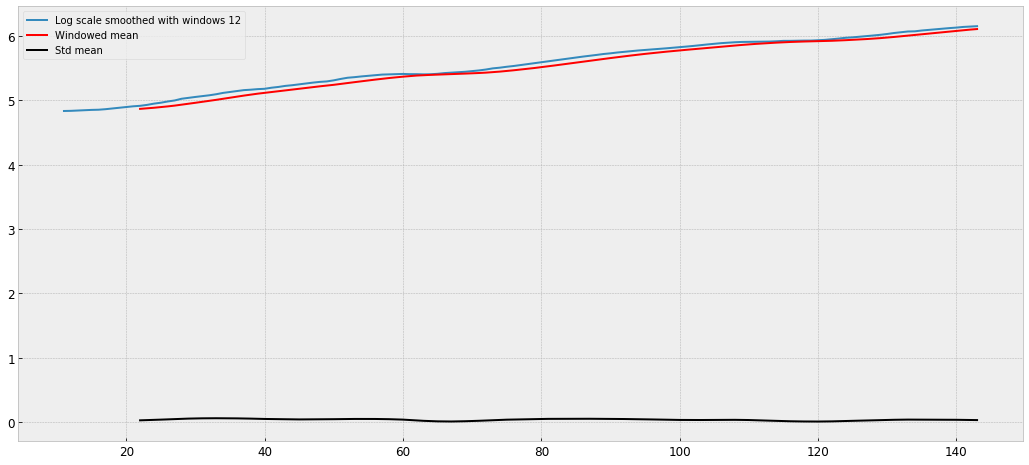

In [24]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()


In [25]:
#WE MAY HAVE APPLIED TOO MANY STUFF HEHE

We can combine it with our previous log scale and apply differencing

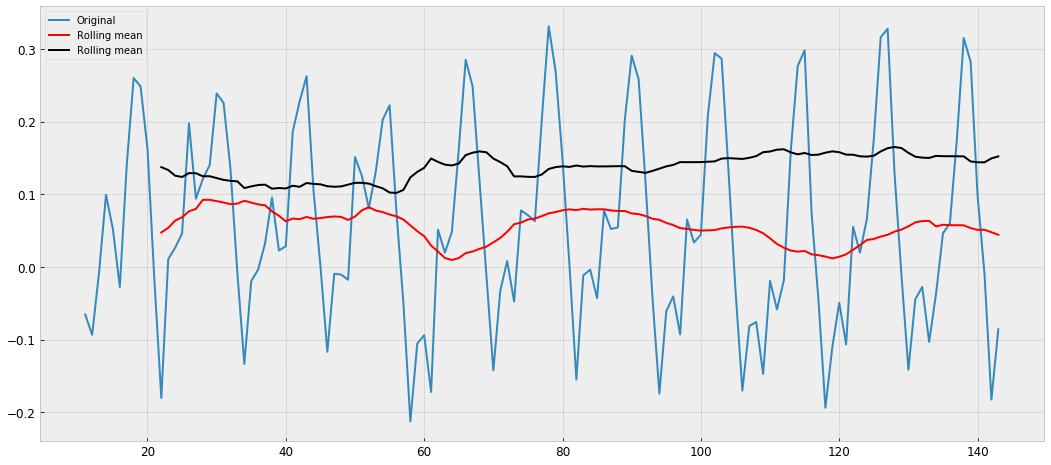

In [26]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(color='red',label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(color='black',label="Rolling mean")
plt.legend(loc='best')

### Moving average

### Decomposition

# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

In [27]:
#We split our dataset to be able to evaluate our models

resultsDict={}

split_date ='2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1461 days of training data 
 364 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

In [28]:
#Also add the naive mean average value
resultsDict['Naive mean'] = evaluate(df_test.pollution_today, df_test.pollution_today.mean())
resultsDict['Yesterdays value'] = evaluate(df_test.pollution_today, df_test.pollution_yesterday)


Unable to compute metric r2: Expected sequence or array-like, got <class 'float'>


## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Autoregression (AR)
- The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

##TO REVIEW

The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AR model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

In [30]:
from statsmodels.tsa.ar_model import AR
from random import random
from beautifultable import BeautifulTable

In [31]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = AR(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['Autoregression'] = evaluate(df_test.pollution_today, yhat.values)

100%|██████████| 364/364 [00:01<00:00, 204.03it/s]


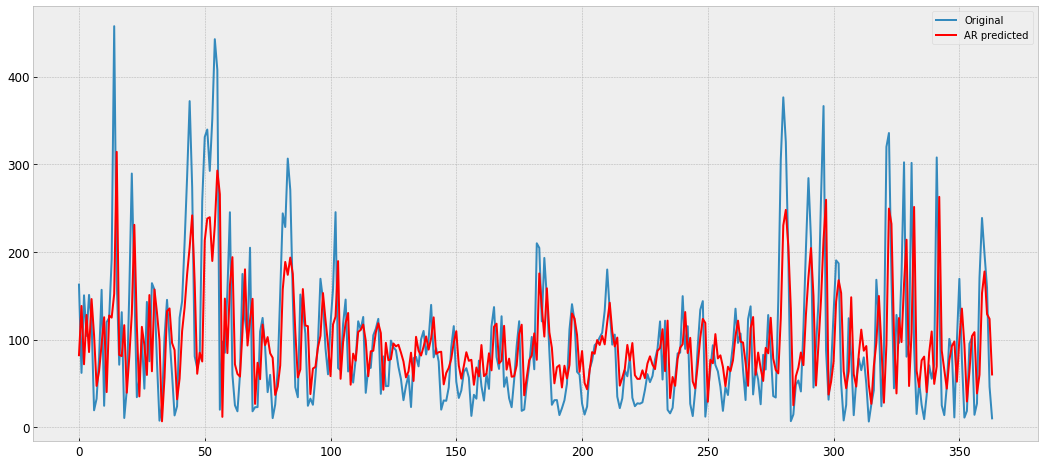

In [32]:
plt.plot(df_test.pollution_today.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

### Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [33]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARMA(temp_train.pollution_today, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['Moving Average'] = evaluate(df_test.pollution_today, yhat.values)

100%|██████████| 364/364 [00:12<00:00, 29.82it/s]


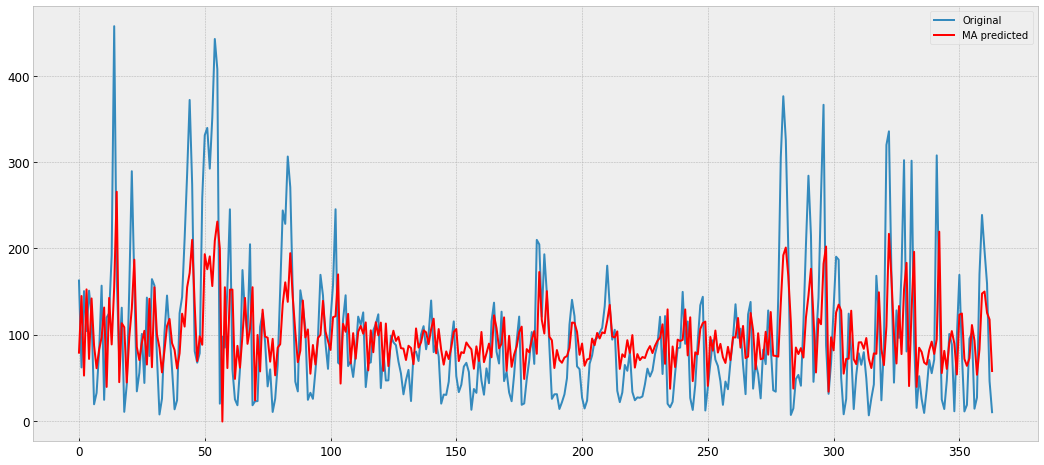

In [34]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='MA predicted')
plt.legend()

### Autoregressive Moving Average (ARMA)

This method will basically join the previous two `AR` and `MA`. 

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [35]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARMA(temp_train.pollution_today, order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['Autoregressive Moving Average'] = evaluate(df_test.pollution_today, yhat.values)

 93%|█████████▎| 340/364 [00:42<00:03,  6.90it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='ARMA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA) 

In [ ]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.pollution_today, yhat.values)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

#### Auto ARIMA

In [ ]:
#building the model
import pmdarima as pm
autoModel = pm.auto_arima(df_training.pollution_today, trace=True, error_action='ignore', suppress_warnings=True,seasonal=False)
autoModel.fit(df_training.pollution_today)

In [ ]:
order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(df_test.pollution_today, yhat)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='AutoARIMA {0}'.format(order))
plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.pollution_today, yhat.values)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

#### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [ ]:
import pmdarima as pm
#building the model
autoModel = pm.auto_arima(df_training.pollution_today, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training.pollution_today)

In [ ]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.pollution_today, order=order, seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.pollution_today, yhat)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

### Prophet

In [ ]:
#Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(columns={'pollution_today': 'y'})  # old method  
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'pollution_today': 'y'})  # old method  
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [ ]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    holidays_prior_scale=20, 
    daily_seasonality=False, 
    weekly_seasonality=False, 
    yearly_seasonality=False
    ).add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=55
    ).add_seasonality(
        name='daily',
        period=1,
        fourier_order=15
    ).add_seasonality(
        name='weekly',
        period=7,
        fourier_order=25
    ).add_seasonality(
        name='yearly',
        period=365.25,
        fourier_order=20
    ).add_seasonality(
        name='quarterly',
        period=365.25/4,
        fourier_order=55
    ).add_country_holidays(country_name='China')

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(df_test.pollution_today, yhat.yhat.values)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet univariate')
plt.legend()

## Multivariate time series forecasting

In [29]:
## ADD time features to our model
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [30]:
X_train, y_train = create_time_features(df_training, target='pollution_today')
X_test, y_test = create_time_features(df_test, target='pollution_today')
scaler = StandardScaler() 
scaler.fit(X_train) #No cheating, never scale on the training+test!
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

### Linear models

#### Bayesian regression

In [31]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test.pollution_today, yhat)

#### Lasso

In [ ]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test.pollution_today, yhat)

### Tree models

#### Randomforest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randoforest'] = evaluate(df_test.pollution_today, yhat)

#### XGBoost

In [ ]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.pollution_today, yhat)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat,color='red',label='XGboost')
plt.legend()

### Support vector machines

Explain multiple kernels balbla

In [ ]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test.pollution_today, yhat)

### Nearest neighbors

In [ ]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.pollution_today, yhat)

### Prophet multivariate

In [ ]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    daily_seasonality=True, 
    ).add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [ ]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate simple DAILY'] = evaluate(y_test, yhat.yhat.values)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet multivariate')
plt.legend()

## Deep learning

### LSTM Pytorch

In [ ]:
#REf https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/
#https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
#https://www.tensorflow.org/tutorials/structured_data/time_series#next_steps

## Tensorlfow tuto

In [423]:
a = np.array([[1,2,3],
              [1,2,3],
              [2,2,3],
              [2,2,3],
              [3,3,3],
              [3,3,3],
              [4,4,4]
])
a[2:4]

array([[2, 2, 3],
       [2, 2, 3]])

In [472]:
window_data(a,[1,2,3,4,5,6,7],window=3)

(array([[[1, 2, 3],
         [1, 2, 3],
         [2, 2, 3]],
 
        [[1, 2, 3],
         [2, 2, 3],
         [2, 2, 3]],
 
        [[2, 2, 3],
         [2, 2, 3],
         [3, 3, 3]],
 
        [[2, 2, 3],
         [3, 3, 3],
         [3, 3, 3]],
 
        [[3, 3, 3],
         [3, 3, 3],
         [4, 4, 4]]]), array([3, 4, 5, 6, 7]))

In [488]:
a[-3:]
a[:-3]

array([[1, 2, 3],
       [1, 2, 3],
       [2, 2, 3],
       [2, 2, 3]])

In [490]:
#For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)

def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]



In [313]:
#Shift pollution_today to last column for easy data splits later
cols = list(air_pollution.columns)
cols = [cols[1:] + [cols[0]]][0]
air_pollution = air_pollution[cols]

In [205]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=x_train_uni.shape[-2:],return_sequences=True),
#     tf.keras.layers.LSTM(128,return_sequences=True),
#     tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [60]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

## Multivariate

In [359]:
BATCH_SIZE = 512
BUFFER_SIZE = 100


train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [360]:
dropout=0.1
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:],return_sequences=True,dropout=dropout),
    tf.keras.layers.GRU(32,return_sequences=True, dropout=dropout),
    tf.keras.layers.SimpleRNN(32,return_sequences=True, dropout=dropout),
    tf.keras.layers.LSTM(32,dropout=dropout),
    tf.keras.layers.Dense(1)
])
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_model.compile(optimizer='RMSprop', loss='mae')

In [361]:
EVALUATION_INTERVAL = 50
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=10)

Train for 50 steps, validate for 10 steps
Epoch 1/10
50/50 [==============================] - 4s 79ms/step - loss: 0.5187 - val_loss: 0.1732
Epoch 2/10
50/50 [==============================] - 0s 6ms/step - loss: 0.2235 - val_loss: 0.1575
Epoch 3/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2124 - val_loss: 0.1512
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2091 - val_loss: 0.1477
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2071 - val_loss: 0.1439
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2063 - val_loss: 0.1411
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2057 - val_loss: 0.1433
Epoch 8/10
50/50 [==============================] - 0s 5ms/step - loss: 0.2028 - val_loss: 0.1389
Epoch 9/10
50/50 [==============================] - 0s 5ms/step - loss: 0.1997 - val_loss: 0.1477
Epoch 10/10
50/50 [==============================] - 0s 5ms/step - loss: 0.

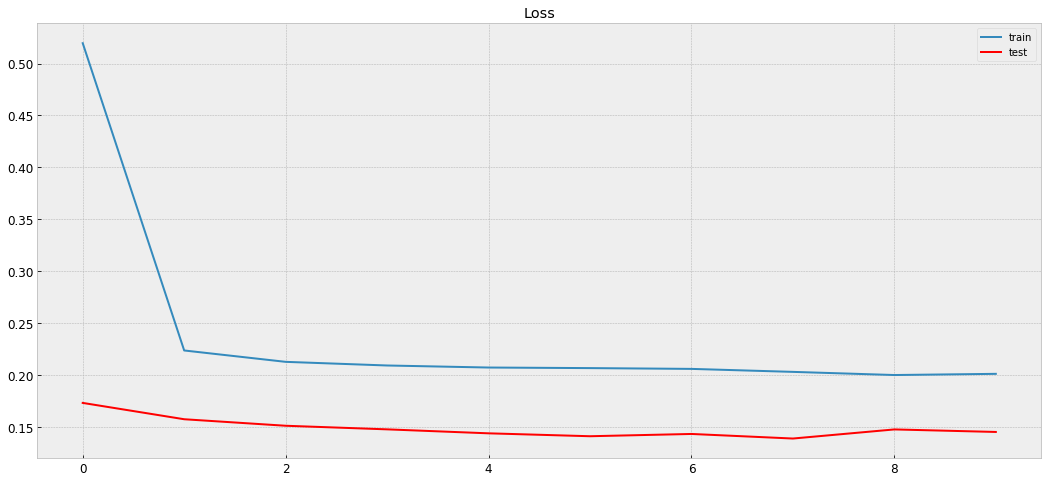

In [362]:
# plot history
plt.plot(single_step_history.history['loss'], label='train')
plt.plot(single_step_history.history['val_loss'], label='test',color='red')
plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
evaluate(y)

In [364]:
len(single_step_model.predict(x_val_single))

364

#  Results

  

## Evaluation Metrics

There are many measures that can be used to analyze the performance of a prediction:


* Mean Absolute Error (MAE) 
* Mean Absolute Percentage Error (MAPE) 
* Root Mean Squared Error (RMSE)
* Symmetric Mean Absolute Percentage Error (MAPE)
* Forecast error (BIAS)
* R2 Coefficient of determination (r2)

In [ ]:
df = pd.DataFrame.from_dict(resultsDict)

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
pallette = plt.cm.get_cmap('tab20c',len(df.columns))
colors = [pallette(x) for x in range(len(df.columns))]
color_dict = dict(zip(df.columns,colors))
fig = plt.figure(figsize=(20, 15))

for irow in range(len(df)):
    ax = fig.add_subplot(4,4,irow+1)
    df.iloc[irow].sort_values().plot(kind='bar', colormap='Paired',color=[color_dict.get(x, '#333333') for x in df.iloc[irow].sort_values().index])
    plt.legend()

plt.tight_layout()
plt.show()


# Additional resources and literature
## Papers

|| |
| - | - |
| Adhikari, R., & Agrawal, R. K. (2013). An introductory study on time series modeling and forecasting.|[[1]](https://arxiv.org/ftp/arxiv/papers/1302/1302.6613.pdf)|

# Appendix

## Hyperparameter optimization

Lets do some hyperparameter optimization!

* Grid search
* Bayesian opt

### Xgboost

In [ ]:
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

def rms(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))
my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 10000),
    'max_depth': (3,15),
    'subsample': (0.0, 1.0),  # Change for big datasets
    'colsample': (0.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}
 
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = xgb.XGBRegressor(
        objective ='reg:squarederror',
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring=my_scorer))
 
optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

In [ ]:
#Extracting the best parameters
params = optimizer.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_xgb = xgb.XGBRegressor(objective ='reg:squarederror',**params)
tunned_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

yhat = tunned_xgb.predict(X_test)
resultsDict['XGBoost Tunned'] = evaluate(y_test, yhat)

In [ ]:
plt.plot(df_test.pollution_today.values , label='Original')
plt.plot(yhat,color='red',label='XGboost Tunned')
plt.legend()

## Ensembling